#  Прогнозирование заказов такси на следующий час

На основе исторических данных о заказах такси в аэропортах, которые собрала компания, предоставляющая услуги такси, требуется построить модель, которая предсказывает количество заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

**Загрузим необходимые бидлиотеки и инструменты.**

In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import time

import warnings
warnings.filterwarnings('ignore')

**Загружаем датасет, одновременно установим индекс таблицы равным столбцу `datetime`, отсортируем по индексу и проверим на монотонность**

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('D:/Яндекс Практикум/22. Временные ряды/taxi.csv', index_col=[0], parse_dates=[0])
    
data.sort_index(inplace=True)
print(data.index.is_monotonic)

True


**Исследуем датасет**

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.isna().sum()

num_orders    0
dtype: int64

**Ресемплируем данные по одному часу**

In [6]:
data = data.resample('1H').sum()

In [7]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Вывод.**

Загрузили и изучили данные. В таблице представлены данные за период с 1 марта по 31 августа 2018 года с интервалом 10 минут. Всего 26496 записей. Пропусков нет. Дубликаты не искали, так как данные могут повторяться.

Выполнили ресемплирование по одному часу. В результате получили таблицу с 4416 строками. Данных для анализа достаточно.

## Анализ

**Посмотрим на тренд, сезонность и остатки.**

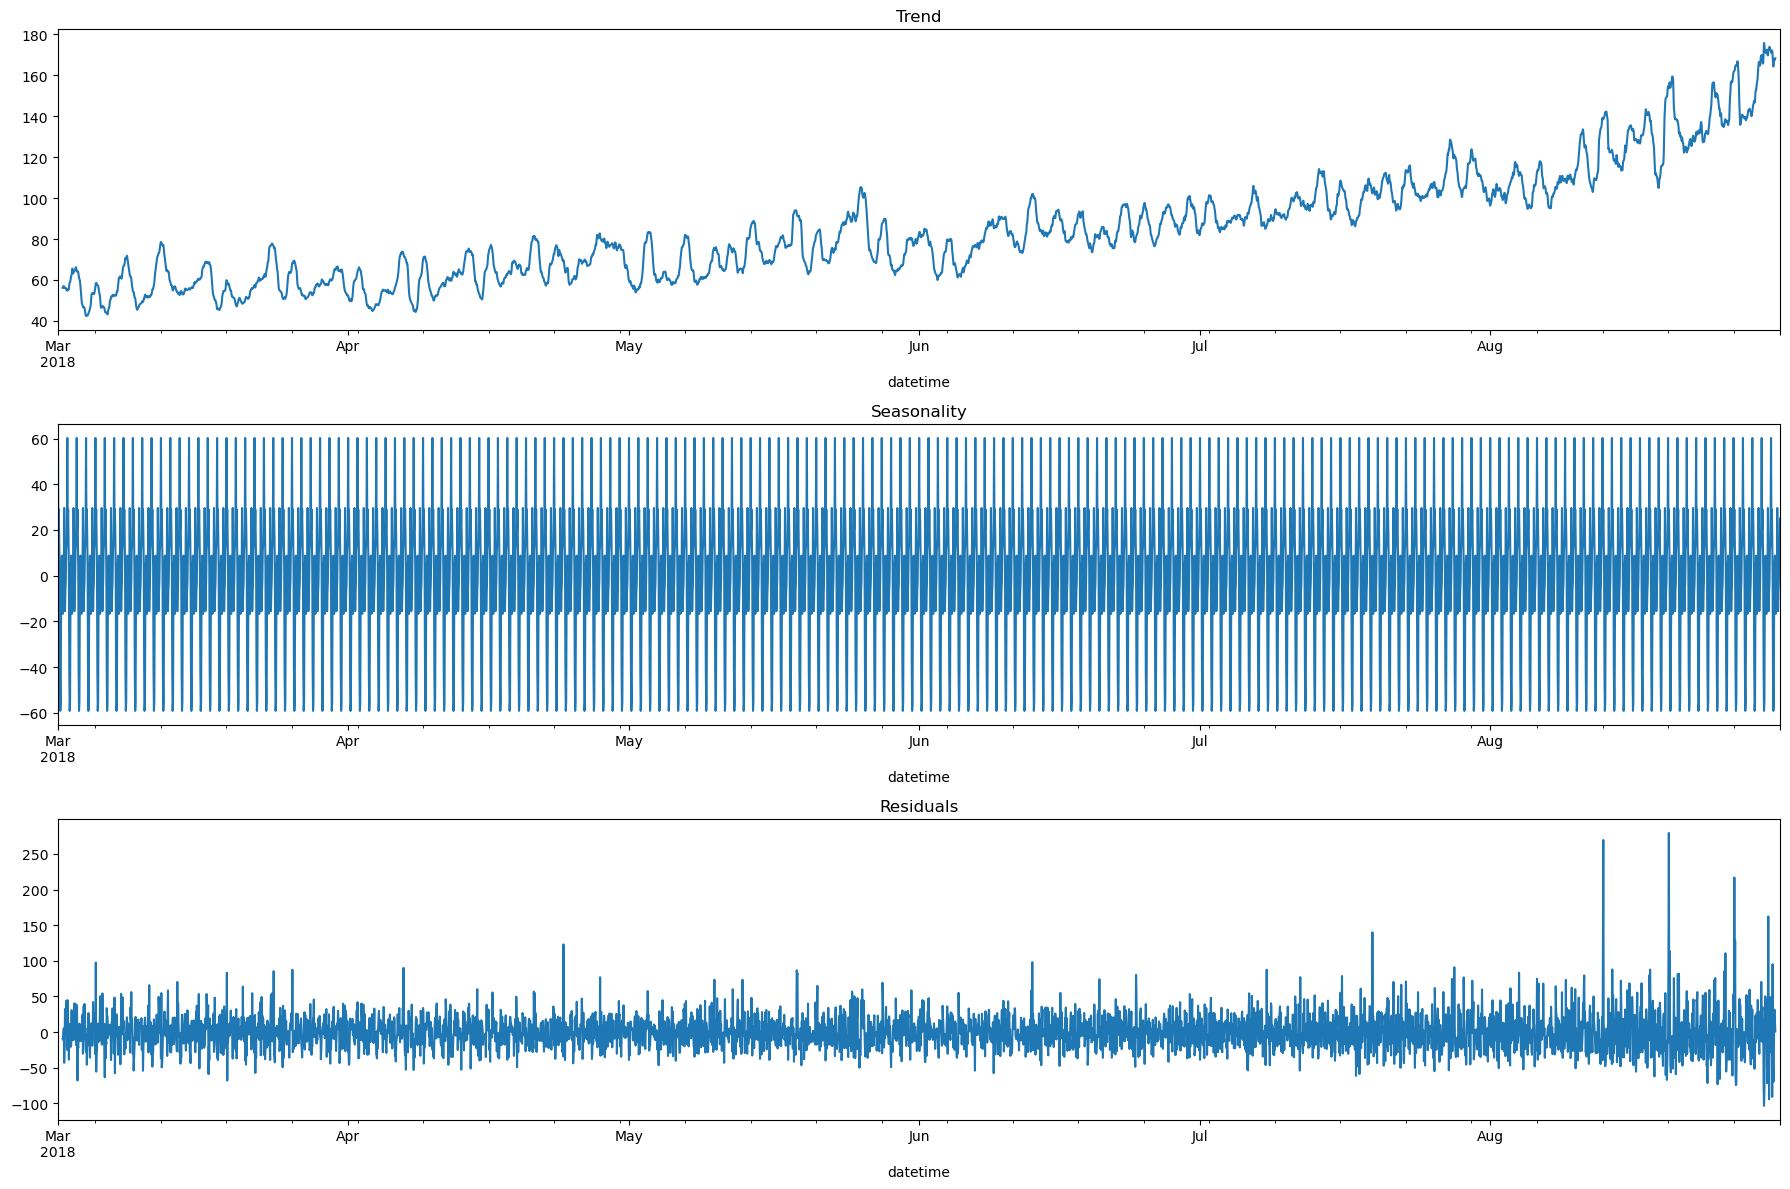

In [9]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(18, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout();

Видно что наблюдается тренд на повышение заказов такси на протяжении всего исследуемого периода, наблюдается суточная сезонность, остатки объяснить невозможно.

Сократим интервал до одного месяца и изучим тренд и сезонность.

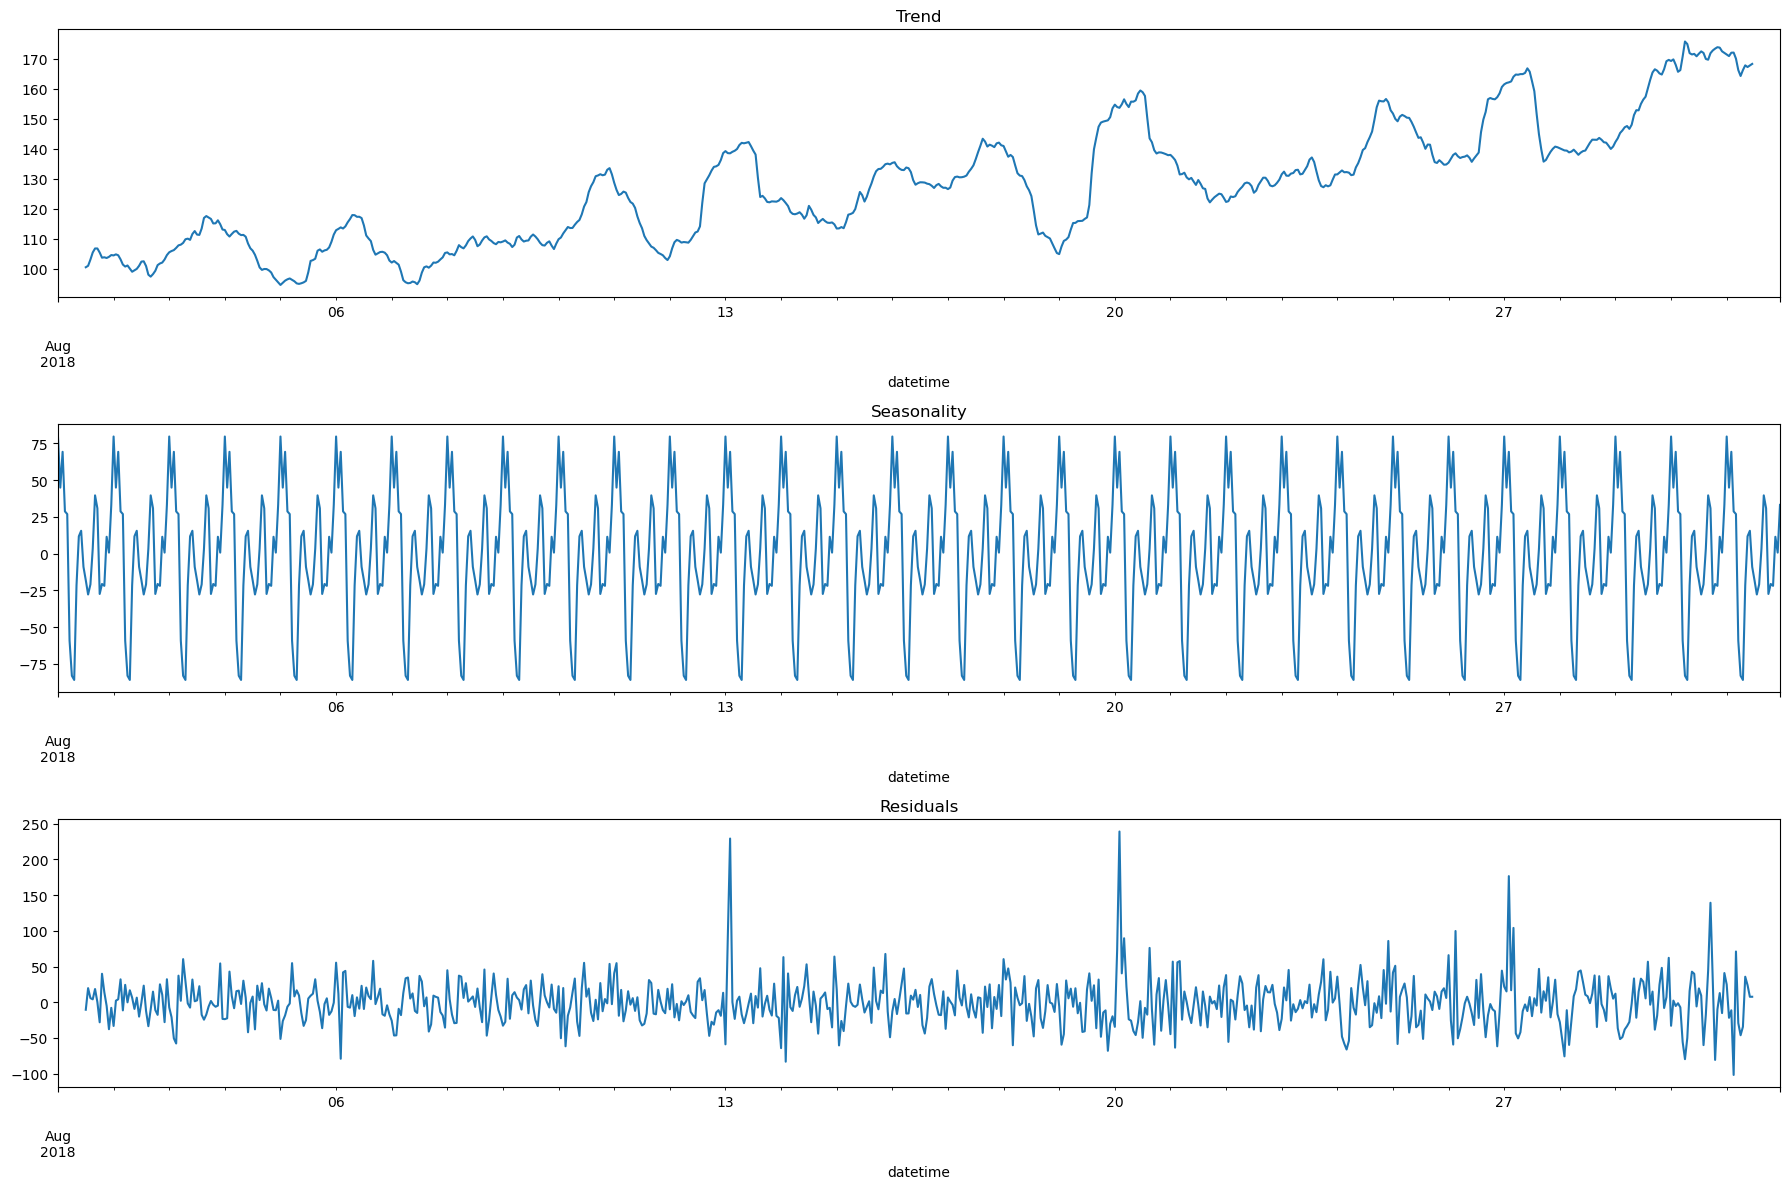

In [10]:
decomposed = seasonal_decompose(data['2018-08-01':])

plt.figure(figsize=(18, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout();

Заметен сезонность по дням недели - увеличение заказов в субботу и понедельник, в воскресенье количество заказов минимально.

Сократим период до трёх дней и посмотрм на графики.

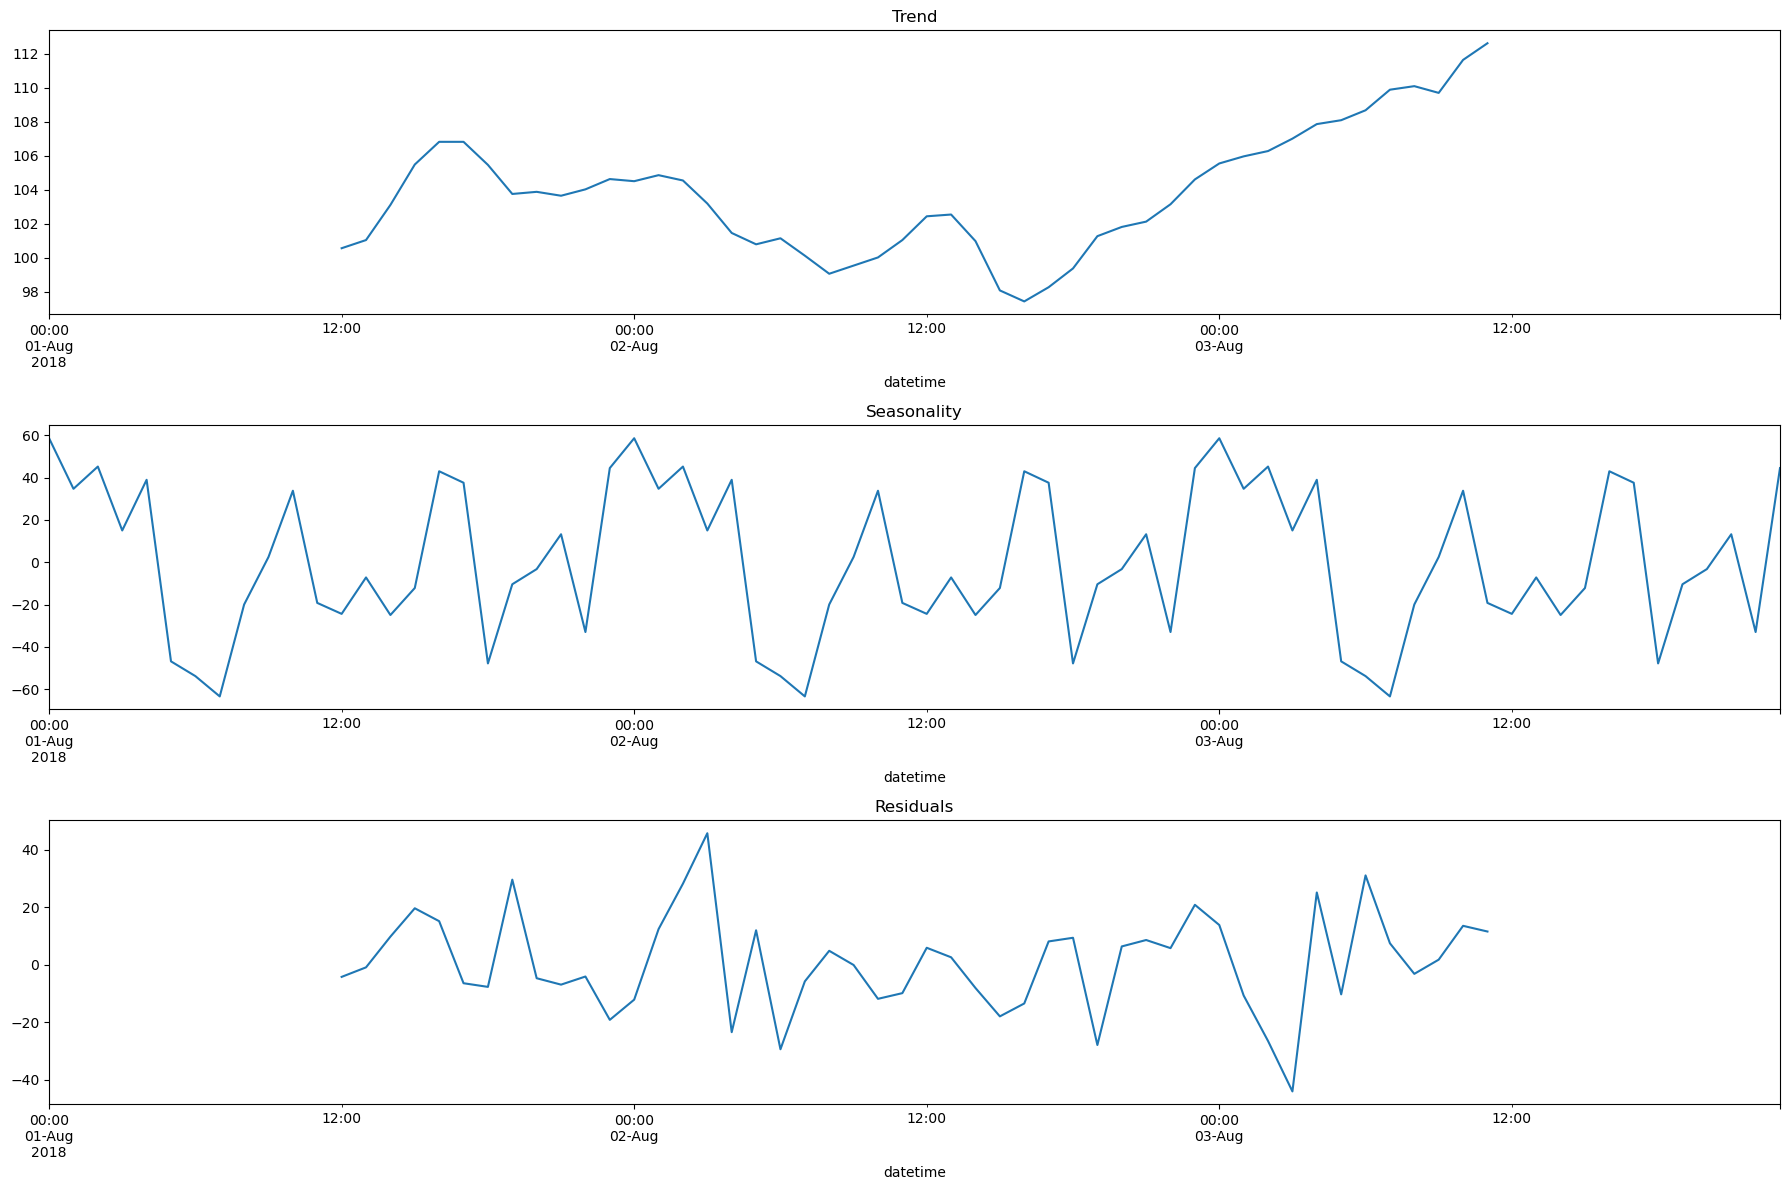

In [11]:
decomposed = seasonal_decompose(data['2018-08-01':'2018-08-03'])

plt.figure(figsize=(18, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout();

Теперь явно видна суточная сезонность. В полночь максимальное количество заказов такси, в семь часов утра - минимальное.

**Найдём скользящее среднее с размером окна одни сутки**

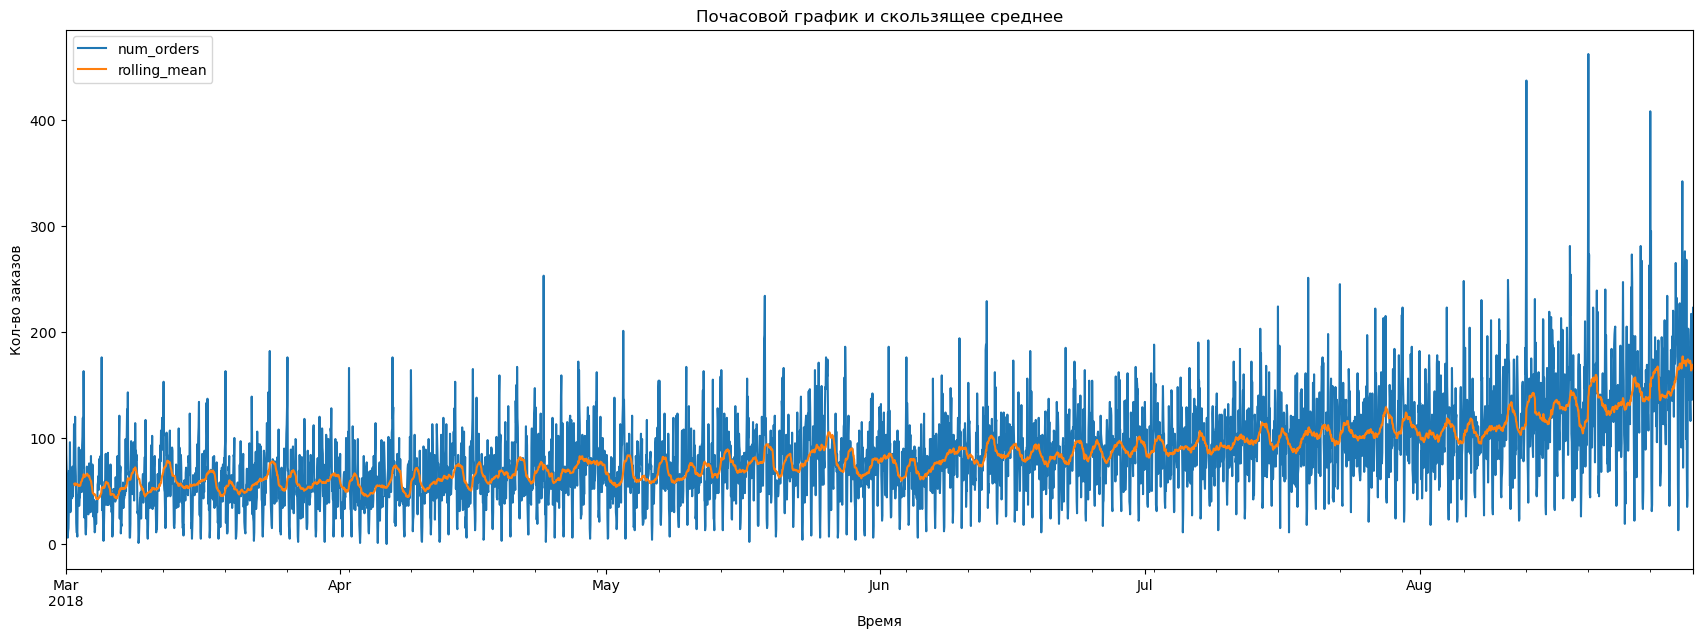

In [12]:
data_plot = data.copy()
data_plot['rolling_mean'] = data_plot.rolling(24).mean()
figsize = (21,7)
data_plot.plot(figsize=figsize)
plt.title('Почасовой график и скользящее среднее')
plt.xlabel('Время')
plt.ylabel('Кол-во заказов')
plt.show();

**Мы имеем нестационарный временной ряд. Вычислим разности временного ряда.**

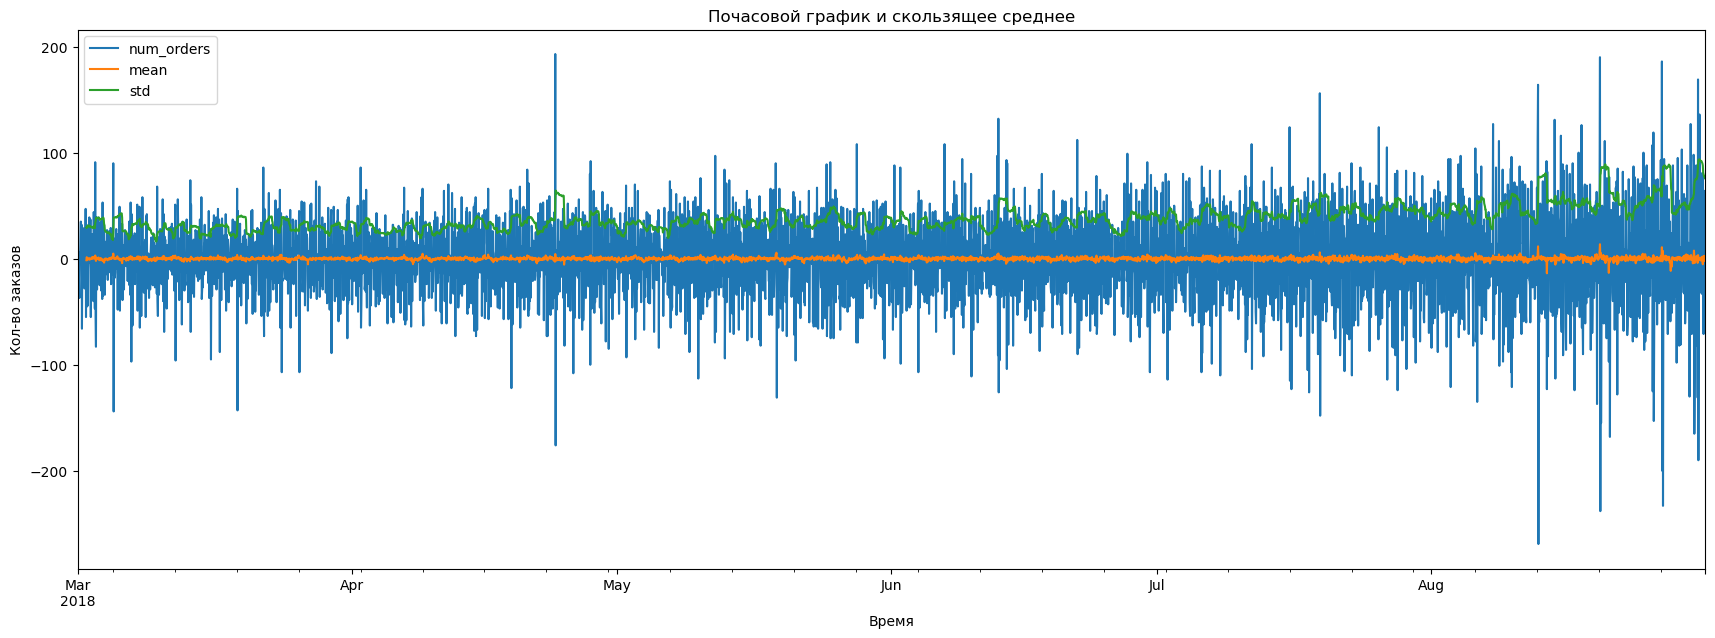

In [13]:
data_sh = data - data.shift()
data_sh['mean'] = data_sh['num_orders'].rolling(24).mean()
data_sh['std'] = data_sh['num_orders'].rolling(24).std()
data_sh.plot(figsize=figsize)
plt.title('Почасовой график и скользящее среднее')
plt.xlabel('Время')
plt.ylabel('Кол-во заказов')
plt.show();

**Вывод.**

Анализ показал, что данные имеют тренд на возрастание, поэтому временной ряд нестационарный. Имеется суточная явная сезонность - максимум заказов в полночь, минимум - в 7 часов утра. Остатки объяснить невозможно. Также оличество заказов зависит от дня недели - в субботу и понедельник максимум заказов, в воскресенье - минимум.

## Обучение

### Подготовка данных для обучения.

**Довавим в таблицу новые признаки месяц, день, день недели, час, а также аргументы max_lag и rolling_mean_size**

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['month'] = data.index.month
    df['day'] = data.index.day
    df['dayofweek'] = data.index.dayofweek
    df['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    df['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

df = make_features(data, 100, 12)

In [15]:
df

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,...,157.0,173.0,152.0,96.0,152.0,111.0,182.0,165.0,195.0,163.416667
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,...,192.0,157.0,173.0,152.0,96.0,152.0,111.0,182.0,165.0,170.916667
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,...,133.0,192.0,157.0,173.0,152.0,96.0,152.0,111.0,182.0,168.583333


**Разделим данные на тренировочную и тестовую выборки.**

In [16]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-05 04:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3874 entries, 2018-03-05 04:00:00 to 2018-08-13 13:00:00
Freq: H
Columns: 106 entries, num_orders to rolling_mean
dtypes: float64(101), int64(5)
memory usage: 3.2 MB


In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Columns: 106 entries, num_orders to rolling_mean
dtypes: float64(101), int64(5)
memory usage: 369.5 KB


**Оценим модель первым способом — прогнозом константой.**

In [19]:
print("Средний объём заказов в час:", test['num_orders'].mean())
 
pred_median = np.ones(test['num_orders'].shape) * train['num_orders'].median()
print("RMSE:", (mean_squared_error(test['num_orders'], pred_median))**0.5)

Средний объём заказов в час: 139.55656108597285
RMSE: 87.15277582981295


**Оценим модель вторым способом — предыдущим значением ряда**

In [20]:
print("Средний объём заказов в час:", test['num_orders'].mean())

pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print("RMSE:", (mean_squared_error(test, pred_previous))**0.5)

Средний объём заказов в час: 139.55656108597285
RMSE: 56.411403911934705


Второй способ точнее первого, однако оба способа доказывают адекватность модели.

**Выделим целевой признак и обучающие признаки.**

In [21]:
target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis=1)

target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)

### Выбор модели обучения.

#### Модель Линейная регрессия.

In [22]:
start_time_lr = time.perf_counter()

lr_param = {'fit_intercept': [True, False],
            'copy_X': [True, False],
            'n_jobs': [-1, 1, None],
            'positive': [True, False]
}

lr_gs = GridSearchCV(LinearRegression(),
                     lr_param, 
                     cv=TimeSeriesSplit(n_splits=5), 
                     scoring = 'neg_mean_squared_error', 
                     n_jobs=-1)

lr_model = lr_gs.fit(features_train, target_train)

best_params_lr = lr_model.best_params_
best_score_lr = -lr_model.best_score_

end_time_lr = time.perf_counter()
execution_time_lr = end_time_lr - start_time_lr

print('Оптимальные параметры:', best_params_lr)
print('RMSE модели:', best_score_lr**0.5)
print('Время обучения: {:.2f} секунд'.format(execution_time_lr))

Оптимальные параметры: {'copy_X': True, 'fit_intercept': False, 'n_jobs': -1, 'positive': False}
RMSE модели: 24.093101504151733
Время обучения: 6.06 секунд


#### Модель Дерево решений.

In [23]:
start_time_dt = time.perf_counter()

param_grid_dt = {
    'max_depth': [2, 4, 6, 8, 10]
}

dt_estimator = DecisionTreeRegressor(random_state=42)

gsearch = GridSearchCV(
    estimator=dt_estimator,
    param_grid=param_grid_dt,
    scoring='neg_mean_squared_error',
    cv=TimeSeriesSplit(n_splits=5),
    n_jobs=-1
)

dt_model = gsearch.fit(features_train, target_train)

best_params_dt = dt_model.best_params_
best_score_dt = -dt_model.best_score_

end_time_dt = time.perf_counter()
execution_time_dt = end_time_dt - start_time_dt

print('Оптимальные параметры:', best_params_dt)
print('RMSE модели:', best_score_dt**0.5)
print('Время обучения: {:.2f} секунд'.format(execution_time_dt))

Оптимальные параметры: {'max_depth': 4}
RMSE модели: 29.10625155590488
Время обучения: 1.35 секунд


#### Модель Случайный лес.

In [24]:
start_time_rf = time.perf_counter()

rf_param = {
    'n_estimators': [65, 70],
    'max_depth': [20, 25, 30]
}

rf_gs = GridSearchCV(RandomForestRegressor(random_state=42, criterion='friedman_mse'),
                     rf_param, 
                     cv=TimeSeriesSplit(n_splits=5), 
                     scoring = 'neg_mean_squared_error', 
                     n_jobs=-1)

rf_model = rf_gs.fit(features_train, target_train)

best_params_rf = rf_model.best_params_
best_score_rf = -rf_model.best_score_

end_time_rf = time.perf_counter()
execution_time_rf = end_time_rf - start_time_rf

print('Оптимальные параметры:', best_params_rf)
print('RMSE модели:', best_score_rf**0.5)
print('Время обучения: {:.2f} секунд'.format(execution_time_rf))

Оптимальные параметры: {'max_depth': 30, 'n_estimators': 65}
RMSE модели: 24.15545231718628
Время обучения: 210.67 секунд


#### Модель градиентного бустинга LightGBM.

In [25]:
start_time_lgb = time.perf_counter()

param_grid = {
    'num_leaves': [71, 81],
    'learning_rate': [0.01, 0.1]
}

lgb_estimator = lgb.LGBMRegressor(task='train', boosting_type='gbdt', objective='regression', verbose=-1)

gsearch = GridSearchCV(estimator=lgb_estimator,
                       param_grid=param_grid, 
                       scoring = 'neg_mean_squared_error', 
                       cv=TimeSeriesSplit(n_splits=5), 
                       n_jobs=-1)
lgb_model = gsearch.fit(features_train, target_train)

best_params_lgb = lgb_model.best_params_
best_score_lgb = -lgb_model.best_score_

end_time_lgb = time.perf_counter()
execution_time_lgb = end_time_lgb - start_time_lgb

print('Лучшие параметры:', best_params_lgb)
print('RMSE модели:', best_score_lgb**0.5)
print('Время обучения: {:.2f} секунд'.format(execution_time_lgb))

Лучшие параметры: {'learning_rate': 0.1, 'num_leaves': 81}
RMSE модели: 24.04712465332413
Время обучения: 12.80 секунд


#### Модель градиентного бустинга CatBoost.

In [26]:
start_time_cb = time.perf_counter()

cb_model = CatBoostRegressor()

param_grid = {
    'learning_rate': [0.01, 0.01, 0.15],
    'depth': [2, 4, 6, 8],
    'iterations': [100, 200]
}

grid_search = GridSearchCV(estimator=cb_model, 
                           param_grid=param_grid, 
                           cv=TimeSeriesSplit(n_splits=5), 
                           scoring = 'neg_mean_squared_error', 
                           n_jobs=-1)

grid_search.fit(features_train, target_train)

best_params = grid_search.best_params_
best_score = -grid_search.best_score_

end_time_cb = time.perf_counter()
execution_time_cb = end_time_cb - start_time_cb

print('Лучшие параметры:', best_params)
print('RMSE модели:', best_score**0.5)
print('Время обучения: {:.2f} секунд'.format(execution_time_cb))

0:	learn: 35.9025189	total: 148ms	remaining: 29.5s
1:	learn: 33.6945014	total: 153ms	remaining: 15.1s
2:	learn: 31.8517658	total: 158ms	remaining: 10.3s
3:	learn: 30.1792431	total: 162ms	remaining: 7.94s
4:	learn: 28.8469968	total: 167ms	remaining: 6.5s
5:	learn: 27.7509247	total: 171ms	remaining: 5.53s
6:	learn: 26.8471375	total: 175ms	remaining: 4.83s
7:	learn: 26.1716016	total: 180ms	remaining: 4.31s
8:	learn: 25.5661869	total: 184ms	remaining: 3.91s
9:	learn: 25.1073912	total: 189ms	remaining: 3.59s
10:	learn: 24.6708042	total: 193ms	remaining: 3.32s
11:	learn: 24.3048902	total: 198ms	remaining: 3.1s
12:	learn: 24.0099220	total: 202ms	remaining: 2.91s
13:	learn: 23.7227553	total: 207ms	remaining: 2.75s
14:	learn: 23.4998829	total: 211ms	remaining: 2.6s
15:	learn: 23.3557862	total: 215ms	remaining: 2.48s
16:	learn: 23.2149276	total: 220ms	remaining: 2.36s
17:	learn: 23.0911066	total: 224ms	remaining: 2.26s
18:	learn: 22.9781502	total: 228ms	remaining: 2.17s
19:	learn: 22.8636827	tot

**Отобразим результаты обучения моделей в сводной таблице.**

In [27]:
lr_results = pd.DataFrame({
    'Модель': ['Линейная регрессия'],
    'RMSE модели': [best_score_lr**0.5],
    'Время обучения, сек.': [execution_time_lr]
})

dt_results = pd.DataFrame({
    'Модель': ['Дерево решений'],
    'RMSE модели': [best_score_dt**0.5],
    'Время обучения, сек.': [execution_time_dt]
})

rf_results = pd.DataFrame({
    'Модель': ['Случайный лес'],
    'RMSE модели': [best_score_rf**0.5],
    'Время обучения, сек.': [execution_time_rf]
})

lgb_results = pd.DataFrame({
    'Модель': ['LightGBM'],
    'RMSE модели': [best_score_lgb**0.5],
    'Время обучения, сек.': [execution_time_lgb]
})

cb_results = pd.DataFrame({
    'Модель': ['CatBoost'],
    'RMSE модели': [best_score**0.5],
    'Время обучения, сек.': [execution_time_cb]
})

results = pd.concat([lr_results, dt_results, rf_results, lgb_results, cb_results], ignore_index=True)
results = results.style.hide_index()
results

Модель,RMSE модели,"Время обучения, сек."
Линейная регрессия,24.093102,6.056716
Дерево решений,29.106252,1.353869
Случайный лес,24.155452,210.672243
LightGBM,24.047125,12.804981
CatBoost,23.967081,162.273929


**Вывод**

Для обучения были выбраны пять моделей - Линейная регрессия, Дерево решений, Случайный лес, LightGBM и CatBoost. Для каждой модели были подобраны гиперпараметры.

Лучшую метрику RMSE - 23.96 показала модель CatBoost, однако у нее очень большое время обучения - 162 секунд. По соотношению скорость обучения/качество лидирует модель Линейная регрессия, у которой RMSE 24.09, а время обучения 6.0 секунды.

Для тестирования выбираем модель Линейная регрессия.

## Тестирование

In [28]:
start_time_rm = time.perf_counter()

regression_model = LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1, positive=False)
regression_model.fit(features_train, target_train)
regression_model_predictions = regression_model.predict(features_test)

regression_RMSE = round(mean_squared_error(target_test, regression_model_predictions), 3)

end_time_rm = time.perf_counter()
execution_time_rm = end_time_rm - start_time_rm

print('RMSE модели Линейной регрессии на тестовой выборке:', regression_RMSE ** 0.5)
print('Время прдсказания: {:.2f} секунд'.format(execution_time_rm))

RMSE модели Линейной регрессии на тестовой выборке: 40.95930907620391
Время прдсказания: 0.04 секунд


In [29]:
lrt_results = pd.DataFrame({
    'RMSE модели': [best_score_lr**0.5],
    'Время обучения, сек.': [execution_time_lr],
    'RMSE предсказания': [mean_squared_error(target_test, regression_model_predictions)**0.5],
    'Время предсказания': [execution_time_rm]
})

lrt_results

,RMSE модели,"Время обучения, сек.",RMSE предсказания,Время предсказания
0,24.093102,6.056716,40.959303,0.044449


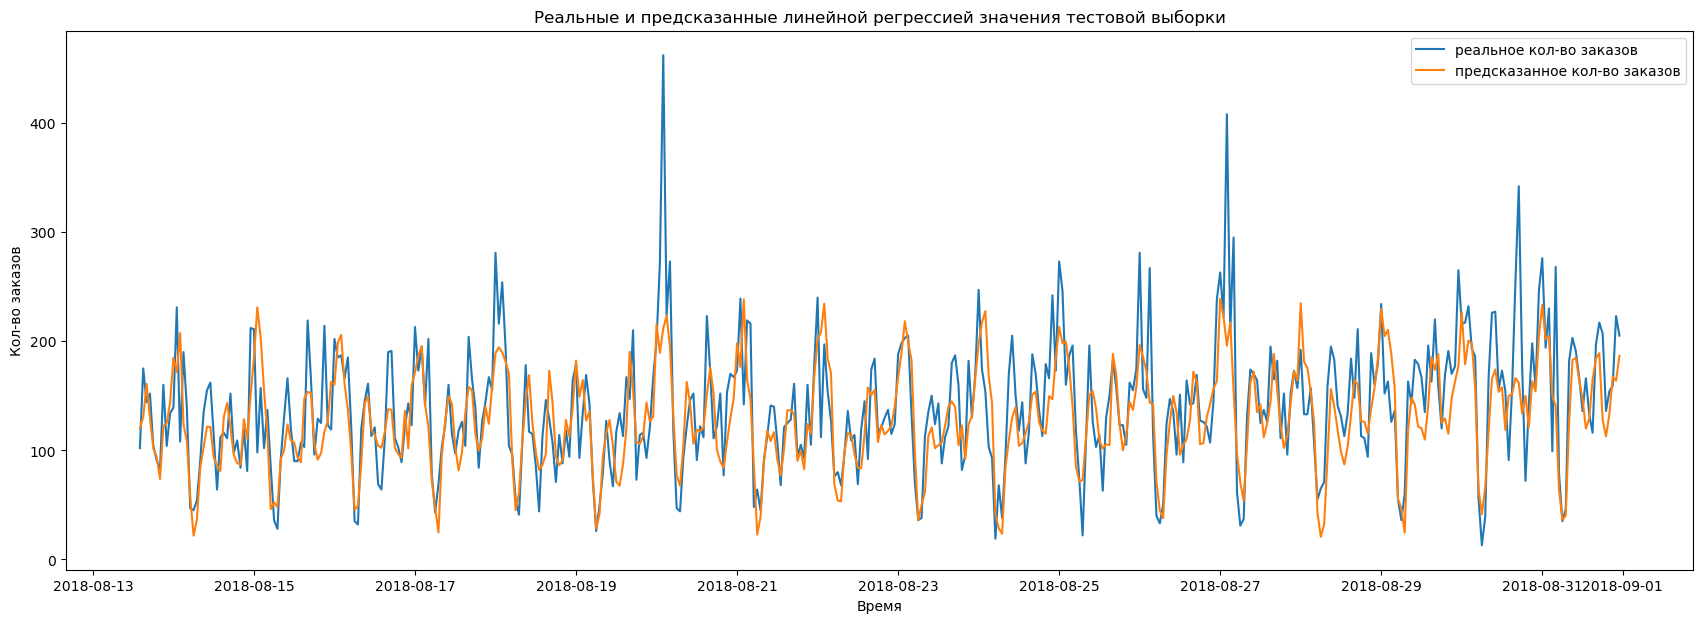

In [30]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(target_test.index, target_test, label='реальное кол-во заказов')
ax.plot(target_test.index, regression_model_predictions, label='предсказанное кол-во заказов')
plt.title('Реальные и предсказанные линейной регрессией значения тестовой выборки')
plt.xlabel('Время')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()

Тестирование модели показало хороший результат. Метрика RMSE - 40.96. График предсказания близок к реальным значениям тестовой выборки.

**Общий вывод**

Нам была поставлена задача подобрать модель для предсказания необходимого количества такси на следующий час в определённом месте.

Для этого нами были изучены предоставленные данные, проведён их анализ, на основе которого данные были подготовлены для обучения.

Для обучения были выбраны пять моделей - Линейная регрессия, Дерево решений, Случайный лес, LightGBM и CatBoost. Для каждой модели были подобраны гиперпараметры.

Для тестирования была выбрана модель Линейная регрессия, у которой метрика RMSE - 24.09, а время обучения - 6.0 секунды.

Метрика RMSE на тестовых данных показала хороший результат - 40.96, что меньше предельно допустимой 48.

Исходя из этого можно сделать вывод, что задача полностью выполнена.